In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision.models import ConvNeXt_Tiny_Weights
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import os
import ast

torch.manual_seed(123456789)

In [16]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
CLASSES = {'biological': 0, 'cardboard': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6} # XL model for bio + trash
SAVE_PATH = "drive/MyDrive/trash_model/morpheus.pth"
DATASET_PATH = "drive/MyDrive/datasets/prediction_model_softmax.csv"

In [25]:
class Predictioner3000(nn.Module):
  def __init__(self, num_inputs, num_outputs):
    super(Predictioner3000, self).__init__()

    self.l1 = nn.Linear(num_inputs, 256)
    self.relu = nn.ReLU()
    self.DO = nn.Dropout(0.2)
    self.l2 = nn.Linear(256, num_outputs)


  def forward(self, x):
    output = self.l1(x)
    output = self.relu(output)
    output = self.DO(output)
    output = self.l2(output)
    return output

def save_model():
    print("... Saving the model")
    torch.save(model.state_dict(), SAVE_PATH)



# Creating the dataset + dataloader

In [26]:
def z_score_normalize(data):
    """
    Z-score normalization technique.
    This function scales the data to have zero mean and unit variance.
    """
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    return normalized_data

class PredictionDataset(Dataset):
  def __init__(self, filename):
    self.data = pd.read_csv(filename)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    inputs = torch.tensor(np.array(ast.literal_eval(self.data.iloc[index, 0])), dtype=torch.float32)
    # turn the targets into one-hot encoded values
    targets = torch.zeros(7)
    targets[self.data.iloc[index, 1]] = 1
    return inputs, targets

In [27]:
dataset = PredictionDataset(DATASET_PATH)

# Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))

# adding +1 to train because the sum of the split is < than the dataset
train_set, val_set = torch.utils.data.random_split(dataset, [train_size+1, val_size])

train_loader = DataLoader(train_set, batch_size=128)
val_loader = DataLoader(val_set, batch_size=128)

print(dataset[0])

(tensor([9.4423e-01, 8.4675e-04, 4.9758e-03, 2.4338e-03, 5.6301e-03, 3.4625e-02,
        7.2551e-03, 7.5358e-02, 7.6751e-02, 1.6102e-01, 2.6445e-01, 2.5490e-01,
        1.6751e-01]), tensor([1., 0., 0., 0., 0., 0., 0.]))


In [33]:
EPOCHS = 200
LR = 0.01

model = Predictioner3000(len(dataset[0][0]), len(dataset[0][1]))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=LR, momentum=0.9, weight_decay=1e-5)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True)

In [34]:
best_loss = 10000
mean_accuracies = []
mean_losses = []

for epoch in range(EPOCHS):

  batch_losses = []
  batch_accs = []

  for batch_idx, (data, target) in enumerate(train_loader):

    data, target = data.to(DEVICE), target.to(DEVICE)

    # reset gradients
    optimizer.zero_grad()

    # run the data trough the model
    y_hat = model(data)

    # calculate loss + acc
    loss = criterion(y_hat, target)
    accuracy = (y_hat.argmax(1) == target.argmax(1)).float().mean()

    # keep track of progress
    batch_accs.append(accuracy)
    batch_losses.append(loss.item())

    if batch_idx % 5 == 0:
        print(f"Batch: {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f} | Accuracy: {accuracy * 100:.4f} | Best: {best_loss:.4f}")

    if loss.item() < best_loss:
        # save the model
        best_loss = loss.item()
        save_model()
        

    loss.backward()
    optimizer.step()


  # calculate mean loss and accuracy for the epoch
  mean_acc, mean_loss = torch.mean(torch.tensor(batch_accs)), torch.mean(torch.tensor(batch_losses))
    
  # print the mean loss and accuracy for the epoch
  print("############################################################################################################")
  print(f"##     Epoch: {epoch+1}/{EPOCHS} | Loss: {mean_loss:.4f} | Accuracy: {mean_acc * 100:.4f}                ##")
  print("############################################################################################################")
  
  # append to the mean loss and accuracy lists for future plotting
  mean_accuracies.append(mean_acc)
  mean_losses.append(mean_loss)
  
  # update the learning rate to counter plateaus
  lr_scheduler.step(loss)

Batch: 1/86 | Loss: 1.9811 | Accuracy: 6.2500 | Best: 10000.0000
... Saving the model
... Saving the model
... Saving the model
... Saving the model
Batch: 6/86 | Loss: 1.8396 | Accuracy: 43.7500 | Best: 1.9026
... Saving the model
... Saving the model
... Saving the model
... Saving the model
... Saving the model
Batch: 11/86 | Loss: 1.7022 | Accuracy: 46.0938 | Best: 1.6722
... Saving the model
... Saving the model
... Saving the model
Batch: 16/86 | Loss: 1.5158 | Accuracy: 57.0312 | Best: 1.5367
... Saving the model
... Saving the model
... Saving the model
... Saving the model
Batch: 21/86 | Loss: 1.2876 | Accuracy: 74.2188 | Best: 1.3691
... Saving the model
... Saving the model
... Saving the model
Batch: 26/86 | Loss: 1.1175 | Accuracy: 84.3750 | Best: 1.1812
... Saving the model
... Saving the model
Batch: 31/86 | Loss: 1.0262 | Accuracy: 80.4688 | Best: 1.0200
... Saving the model
... Saving the model
Batch: 36/86 | Loss: 0.9397 | Accuracy: 84.3750 | Best: 0.9032
... Saving t

In [35]:
model.load_state_dict(torch.load(SAVE_PATH))
model.eval()
val_batch_losses = []
val_batch_accs = []
val_batch_idx = []

with torch.no_grad():

  for batch_idx, (data, target) in enumerate(val_loader):
    data = data.to(DEVICE)
    target = target.to(DEVICE)

    y_hat = model(data)
    loss = criterion(y_hat, target)
    accuracy = (y_hat.argmax(1) == target.argmax(1)).float().mean()

    print(f"Validation: Loss: {loss.item()} | Accuracy: {accuracy * 100}")

    val_batch_accs.append(accuracy)
    val_batch_losses.append(loss.item())
    val_batch_idx.append(batch_idx)

Validation: Loss: 0.1905509978532791 | Accuracy: 95.3125
Validation: Loss: 0.1290026307106018 | Accuracy: 95.3125
Validation: Loss: 0.13259918987751007 | Accuracy: 96.875
Validation: Loss: 0.15901698172092438 | Accuracy: 96.09375
Validation: Loss: 0.09386563301086426 | Accuracy: 98.4375
Validation: Loss: 0.06736253201961517 | Accuracy: 99.21875
Validation: Loss: 0.08935090154409409 | Accuracy: 97.65625
Validation: Loss: 0.09802038222551346 | Accuracy: 97.65625
Validation: Loss: 0.08411247283220291 | Accuracy: 98.4375
Validation: Loss: 0.13511446118354797 | Accuracy: 97.65625
Validation: Loss: 0.17631125450134277 | Accuracy: 95.3125
Validation: Loss: 0.26650696992874146 | Accuracy: 94.53125
Validation: Loss: 0.15943527221679688 | Accuracy: 95.3125
Validation: Loss: 0.1567809134721756 | Accuracy: 96.875
Validation: Loss: 0.14324939250946045 | Accuracy: 96.875
Validation: Loss: 0.18669277429580688 | Accuracy: 95.3125
Validation: Loss: 0.20304812490940094 | Accuracy: 95.3125
Validation: Lo

# Visualise val + train

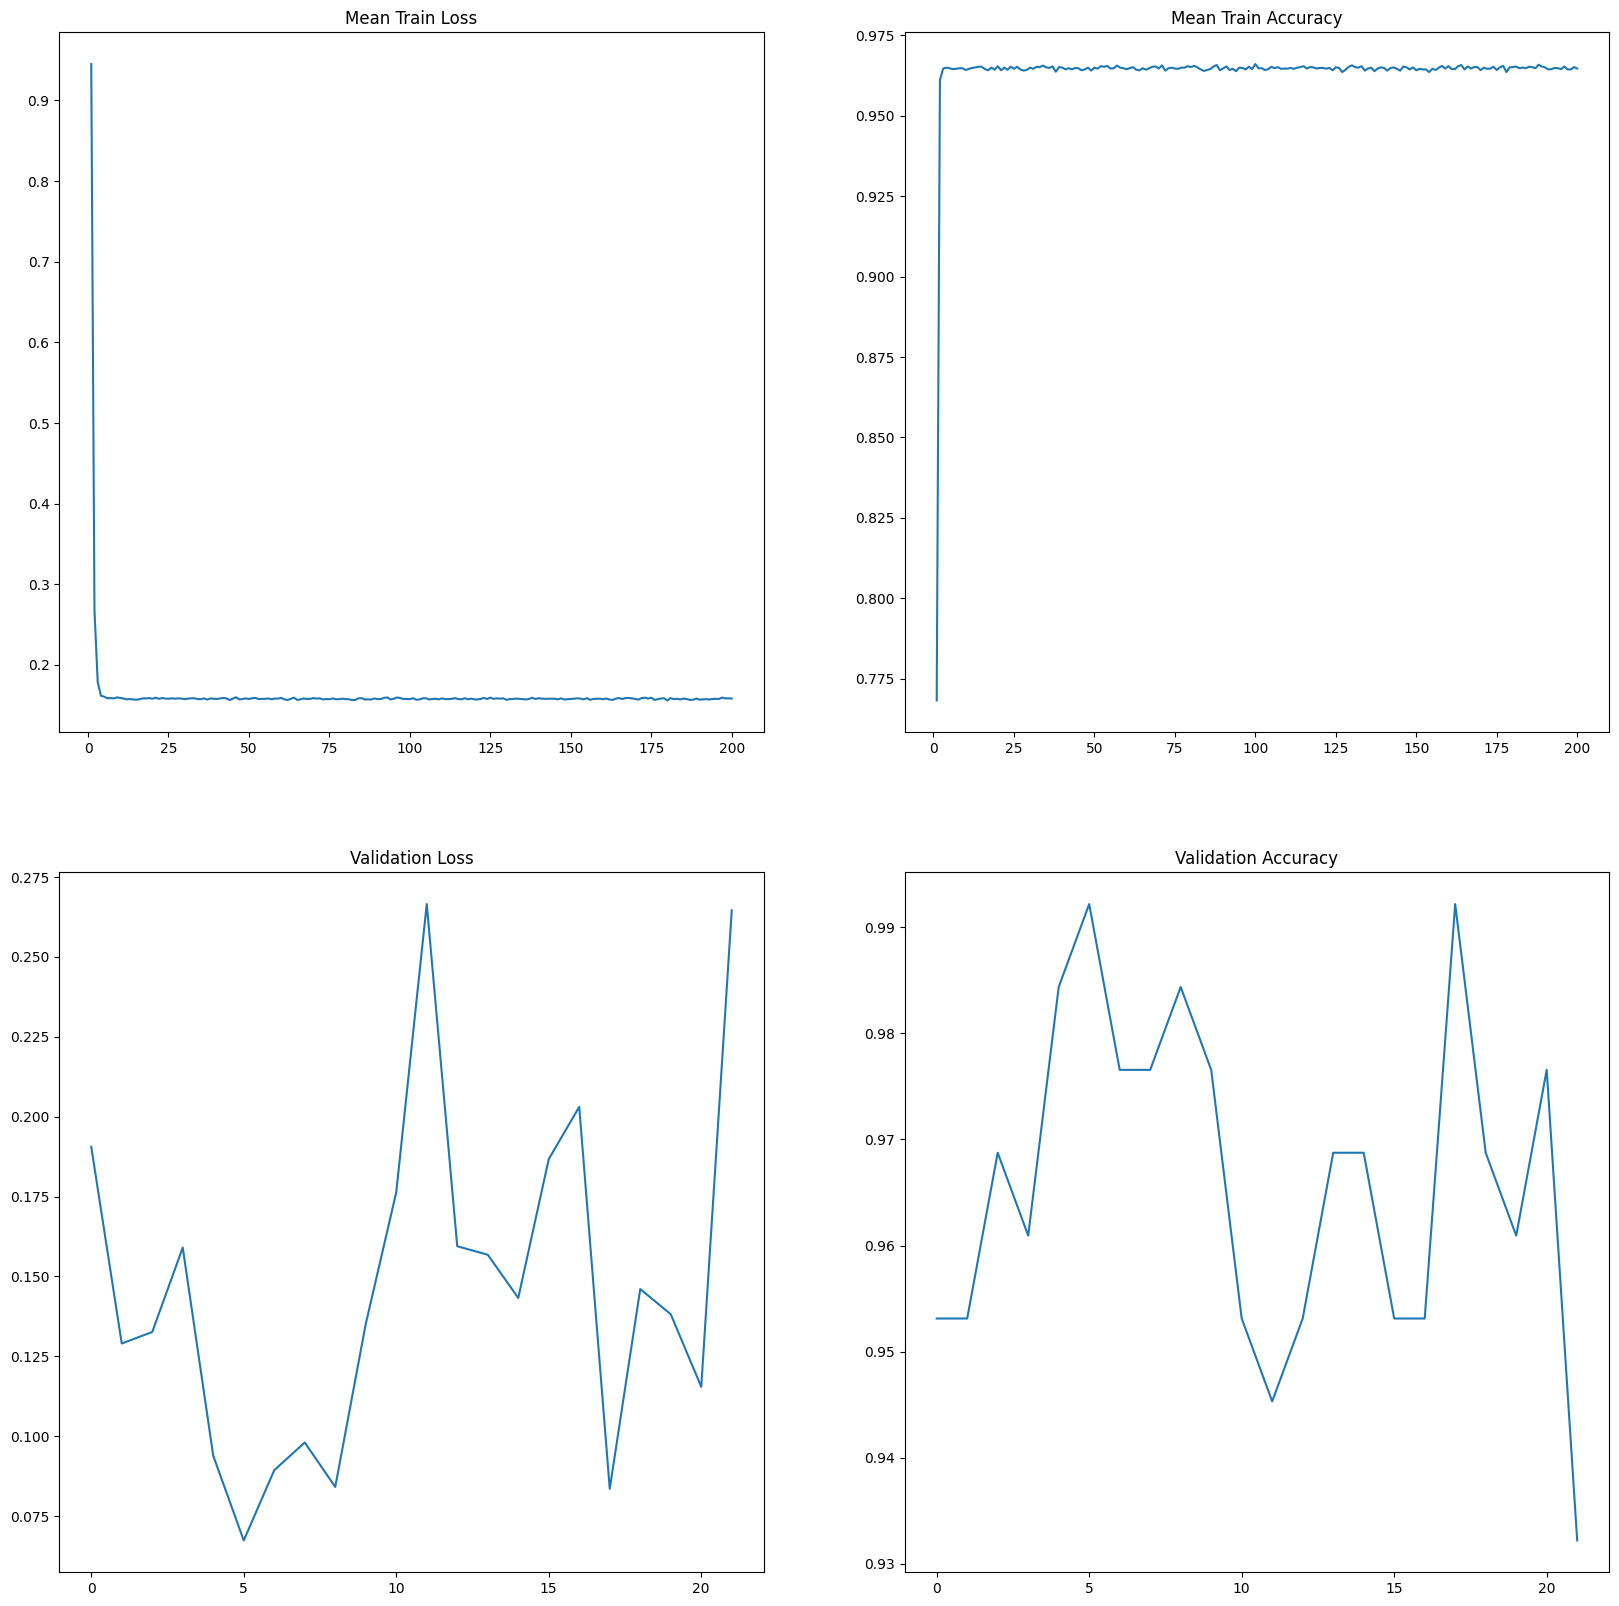

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

ax[0][0].plot([e+1 for e in range(len(mean_losses))], mean_losses)
ax[0][0].set_title("Mean Train Loss")


ax[0][1].plot([e+1 for e in range(len(mean_accuracies))], mean_accuracies)
ax[0][1].set_title("Mean Train Accuracy")


ax[1][0].plot(val_batch_idx, val_batch_losses)
ax[1][0].set_title("Validation Loss")

ax[1][1].plot(val_batch_idx, val_batch_accs)
ax[1][1].set_title("Validation Accuracy")


plt.show()

# Test the model on real data

In [48]:
trash1 = [0.0086, 0.2149, 0.0183, 0.0589, 0.1605, 0.5314, 0.0073, 0.0132, 0.0008, 0.2566, 0.1004, 0.0153, 0.6138] # doritos
bio1 = [0.7083, 0.0622, 0.0178, 0.0271, 0.1607, 0.0209, 0.0031, 0.0715, 0.0420, 0.1698, 0.2963, 0.1590, 0.2613] # apple 2
bio2 = [0.4447, 0.0101, 0.0047, 0.0053, 0.5093, 0.0242, 0.0018, 0.0364, 0.0226, 0.1424, 0.2065, 0.1036, 0.4886] # apple 3
trash2 = [0.0590, 0.2366, 0.0225, 0.0727, 0.0768, 0.5171, 0.0154, 0.0674, 0.0075, 0.2383, 0.1671, 0.1017, 0.4179]# ramen pack
plastic = [4.0067e-04, 8.3547e-04, 4.3519e-03, 3.0722e-03, 5.8042e-03, 9.8539e-01, 1.4714e-04, 3.1806e-03, 3.1423e-03, 2.8935e-01, 1.7050e-02, 6.8135e-02, 6.1915e-01] # plastic
trash3 = [2.5650e-04, 7.4327e-01, 5.5959e-04, 1.2665e-02, 8.2875e-03, 2.3491e-01, 5.2167e-05, 4.9872e-02, 9.0184e-03, 1.3078e-01, 2.8780e-02, 3.1528e-02, 7.5002e-01] # candy bar
bio3 = [0.3621, 0.0463, 0.0470, 0.0411, 0.1047, 0.2666, 0.1323, 0.1116, 0.1403, 0.1893, 0.1681, 0.1728, 0.2179] # banana 1
bio4 = [0.4377, 0.0282, 0.0242, 0.0318, 0.3746, 0.0543, 0.0492, 0.0633, 0.0812, 0.3076, 0.2178, 0.0670, 0.2632] # banana 2

items = [(trash1, "trash"), (bio1, "biological"), (bio2, "biological"), (trash2, "trash"), (plastic, "plastic"), (trash3, "trash"), (bio3, "biological"), (bio4, "biological")]

for (item, label) in items:
  input_data = torch.tensor(item)
  pred = model(input_data)
  pred = pred.argmax(0)
  pred = list(CLASSES.keys())[pred]

  print(label, " --> ", pred)


trash  -->  plastic
biological  -->  biological
biological  -->  paper
trash  -->  plastic
plastic  -->  plastic
trash  -->  cardboard
biological  -->  biological
biological  -->  biological
